In [42]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import copy
from mapping_fxns import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Quantile mapping for climate data

This script contains code to perform quantile mapping from MERRA-2 data to in-situ observations from a weather station. 

### All the lines you should need to edit are in the cell below, but you should inspect the figures generated with get_scatter_plot and get_quantile_plot to try and catch any mistakes.

In [43]:
# ========= WEATHER STATION INFO =========
# Station location
# # KAHILTNA
glacier = 'kahiltna'               # Glacier name consistent with glacier_metadata file in PEBSI/data
lat = 63.07	                       # Station latitude [decimal degrees]
lon = -151.17                      # Station ongitude [decimal degrees]
elev_AWS = 2377                    # Station elevation [m a.s.l.]
timezone = 0                       # Station time zone compared to UTC [hrs] (if the AWS time is in UTC, this should be 0)
time_col=0

# AWS file information
fp_AWS = 'climate_data/AWS/'       # Filepath to processed AWS data
fn_AWS = fp_AWS + 'Raw/kahiltna/NPS/preprocessed_2018.csv'          # Filename of AWS data to use in mapping

# # Station location
# # BENCHMARK
# glacier = 'gulkana'                # Glacier name consistent with glacier_metadata file in PEBSI/data
# lat = 60.381923                   # Station latitude [decimal degrees]     WOLV: 60.381923     GULKANA:63.285514
# lon = -148.939662                   # Station ongitude [decimal degrees]     WOLV: -148.939662   GULKANA: -145.410
# elev_AWS = 1725                    # Station elevation [m a.s.l.]            WOLV: 990, 1420     GULKANA: 1725
# timezone = 0                       # Station time zone compared to UTC [hrs] (if the AWS time is in UTC, this should be 0)
# time_col = 'UTC_time'

# # AWS file information
# fp_AWS = 'climate_data/AWS/'       # Filepath to processed AWS data
# if glacier == 'gulkana':
#     fn_AWS = fp_AWS + f'Raw/Benchmark/{glacier}/{elev_AWS}/LVL2/{glacier}{elev_AWS}_hourly_LVL2_ALL.csv'          # Filename of AWS data to use in mapping
# else:
#     fn_AWS = fp_AWS + f'Raw/Benchmark/{glacier}/LVL2/{glacier}{elev_AWS}_hourly_LVL2.csv'

# ========= MERRA-2 INFO =========
start_MERRA2_data = pd.to_datetime('1980-01-01 00:30')  # First timestamp in MERRA-2 data
end_MERRA2_data = pd.to_datetime('2025-06-30 00:30')    # Last timestamp in MERRA-2 data
MERRA2_filetag = glacier+'_alltime.nc'                  # False to use lat/lon indexed files, otherwise string to follow 'MERRA2_VAR_'

# ========= VARIABLE =========
# Define name of variable
var = 'temp'                          # Name of var as referenced in PEBSI (see var_dict keys below if unsure)
var_AWS = 'AirTemp_C_Avg'                  # Name of var in the AWS data

# Define unit conversion for units of MERRA-2 and AWS data
def MERRA2_unit_conversion(data):
    if var == 'temp':
        return data - 273.15
    elif var == 'SWin':
        return data * 3600
    else:
        return data
def AWS_unit_conversion(data):
    if var == 'SWin':
        return data * 3600
    else:
        return data

# ======== VISUALIZATION ========
get_scatter_plot = True         # *** Plots 1:1 AWS vs. MERRA-2 data
get_quantile_plot = True        # *** Plots distribution of AWS and MERRA-2 data before and after correction

In [44]:
# ========= FILEPATHS =========
fp_base = os.getcwd() + '/../../../'    # Base filepath to direct files to
fn_AWS = fp_base + fn_AWS
assert os.path.exists(fn_AWS), f'AWS dataset not found at {fn_AWS}'
# MERRA-2
fp_MERRA = fp_base + 'climate_data/MERRA2/'             # Filepath to MERRA-2 data
fn_MERRA = fp_MERRA + 'VAR/MERRA2_VAR_LAT_LON.nc'       # Formattable file name for MERRA-2 variable data
# OUTPUT
fn_store_quantiles = fp_base + f'PEBSI/data/bias_adjustment/quantile_mapping_{glacier}_VAR.csv'     # Filename to store quantiles
fn_store_fig = fp_base + f'Output/{glacier}_{var}_quantile_mapping.png'                                          # Filename to store figures

# Get MERRA-2 elevation (gepotential)
ds_elev = xr.open_dataarray(fp_MERRA + 'MERRA2constants.nc4')
elev_MERRA2 = ds_elev.sel(lat=lat,lon=lon,method='nearest').values[0] / 9.81

# Update MERRA-2 filepath
flat = str(int(np.floor(lat/10)*10))        # Latitude rounded to 10 degrees to find the right file
flon = str(int(np.floor(lon/10)*10))        # Longitude rounded to 10 degrees to find the right file
if not MERRA2_filetag:
    fn_MERRA = fn_MERRA.replace('LAT', str(flat)).replace('LON', str(flon))
else:
    fn_MERRA = fn_MERRA.replace('LAT_LON.nc', MERRA2_filetag)

### Load and clean the data

You likely need to make minor edits to this code to ensure the data is loaded properly and you are comparing what you want to compare. For example, you will need to check the units of the data you're inputting and put both the AWS and MERRA-2 data into the units the model takes (see process_AWS.ipynb for this information)

In [53]:
# ======== LOAD DATA ========
# Dictionary for each variable that may be mapped to data
var_dict = {'SWin':{'MERRA2_var':'SWGDN', 'label':'Incoming shortwave (W m-2)','lims':[0,1400*3600]},
            'LWin':{'MERRA2_var':'LWGAB', 'label':'Incoming shortwave (W m-2)','lims':[0,500*3600]},
            'temp':{'MERRA2_var':'T2M', 'label':'Air temperature ($^{\circ}$C)','lims':[-60,50]},
            'wind':{'MERRA2_var':'U2M', 'label':'Wind speed (m s-1)','lims':[0,70]},
            'rh':{'MERRA2_var':'RH2M', 'label':'Relative humidity (%)','lims':[0,100]},
            'sp':{'MERRA2_var':'PS', 'label':'Surface pressure (Pa)','lims':[6e4,1.2e4]}}

# Select variable name and label from var_dict
var_MERRA2 = var_dict[var]['MERRA2_var']        # Name of var in the MERRA-2 data
var_label = var_dict[var]['label']              # Label for plotting
lims = var_dict[var]['lims']

# Open datasets
data_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR',var_MERRA2))
data_AWS = pd.read_csv(fn_AWS, index_col=time_col)[var_AWS]

# Wind is treated differently since it is broken into east and west components by MERRA-2
either_wind = ['U2M','V2M']
if var_MERRA2 in either_wind:
    either_wind.remove(var_MERRA2)
    other_variable = either_wind[0]
    data_MERRA2_other = xr.open_dataarray(fn_MERRA.replace('VAR',other_variable))
    data_MERRA2.values = np.sqrt(data_MERRA2.values**2 + data_MERRA2_other.values**2)

# Clip MERRA-2 dataset to the right lat/lon
if not MERRA2_filetag:
    data_MERRA2 = data_MERRA2.sel(lat=lat,lon=lon, method='nearest')
else:
    data_MERRA2 = data_MERRA2

# ======== ELEVATION DEPENDENCE ========
if var == 'temp':
    lapse_rate = -7           # Lapse rate [K km-1]
    data_AWS += (elev_MERRA2 - elev_AWS) * lapse_rate / 1000

# ======== CHECK VALUES ========
# Update units to match the AWS
data_MERRA2 = MERRA2_unit_conversion(data_MERRA2)
data_AWS = AWS_unit_conversion(data_AWS)

# Check for unreasonable values
upper_lim = lims[1]
lower_lim = lims[0]
data_AWS = data_AWS[(data_AWS.values >= lower_lim) & (data_AWS.values <= upper_lim)]

Clip the datasets to the time periods where the AWS has data.

In [54]:
# ======== TIME ========
# Define all_MERRA2 variable
all_MERRA2 = data_MERRA2.values

# Make sure AWS data is using datetime index
data_AWS.index = pd.to_datetime(data_AWS.index)

# Convert AWS time to UTC
data_AWS.index -= pd.Timedelta(hours=timezone)

# Find dates where AWS recorded temperature
dates_data = pd.to_datetime(data_AWS.index[~np.isnan(data_AWS)])

# Filter out dates that are outside of MERRA-2 range
dates_data = dates_data[dates_data >= start_MERRA2_data]
dates_data = dates_data[dates_data <= end_MERRA2_data]

# Make sure there are not repeated values
dates_data = np.unique(dates_data)

# Select dates where AWS has data
data_MERRA2['time'] = pd.to_datetime(data_MERRA2['time'].values)
data_MERRA2 = data_MERRA2.interp(time=pd.to_datetime(dates_data).tz_localize(None))
data_AWS = data_AWS.loc[dates_data]

Perform quantile mapping and generate plots to inspect the results. It is crucial to inspect the plot of the updated distribution of all MERRA-2 data to ensure the distribution matches the AWS distribution better than the original MERRA-2 data. 

For example, If your AWS only operates over the summer, correcting year-round temperature or shortwave data will skew results, as the distribution of values is very different winter to summer. 

stored to c:\Users\cvw30\Research\Model\PEBSI\pebsi\preprocessing/../../../PEBSI/data/bias_adjustment/quantile_mapping_kahiltna_temp.csv


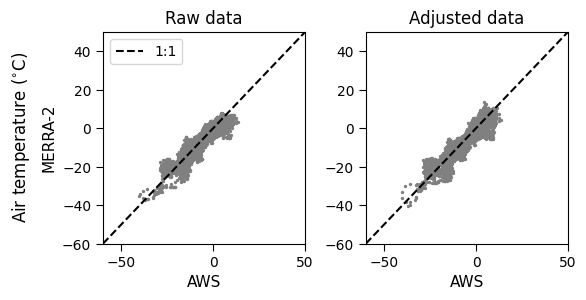

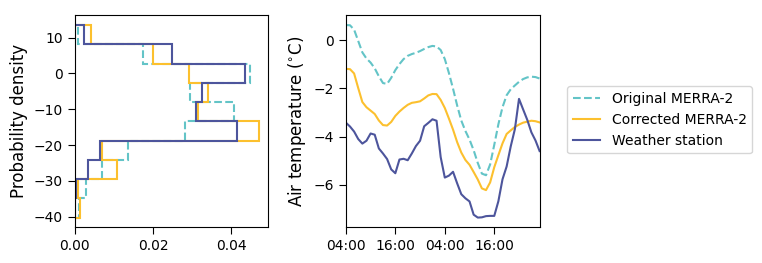

In [55]:
# Separate data into train and test
X_train = data_AWS.values
y_train = data_MERRA2.values

# Get quantile mapping and store it
fn = fn_store_quantiles.replace('VAR',var) # .replace('gulkana','gulkana_elevwolverine')
sorted, mapping = quantile_mapping(X_train, y_train, fn)

# Plot scatter plot
if get_scatter_plot:
    fig, axes = plot_scatter(X_train, y_train, lims, fn, plot_kde=False)
    fig.supylabel(var_label,x=-0.03)
    plt.show()

# Select time range for plot_quantile subplot
time = select_random_48hr_window(data_AWS)

# Create the timed variable for quantile function
raw = data_MERRA2.sel(time=time)
adj = np.interp(raw, sorted, mapping)
aws = data_AWS.loc[time]

# Convert back to local time for plotting
time += pd.Timedelta(hours=timezone)
timed_tuple = (time, raw, adj, aws)

# Plot quantiles
if get_quantile_plot:
    fig, axes = plot_quantile(X_train, y_train, all_MERRA2, timed_tuple, fn)
    axes[-1].set_ylabel(var_label,fontsize=12)
    plt.savefig(fn_store_fig,dpi=200,bbox_inches='tight')
    plt.show()

## Inspect metrics before and after

The goal of quantile mapping is to remove bias, so after performing this correction you should see the bias decrease. MAE and RMSE may increase, and if they do substantially you may want to inspect your plots and make sure the timing matches up.

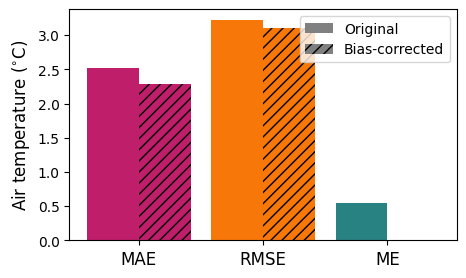

In [56]:
MAE_before = np.mean(np.abs(y_train - X_train))
ME_before = np.mean(y_train - X_train)
RMSE_before = np.sqrt(np.mean(np.square(y_train - X_train)))
y_adj = np.interp(y_train, sorted, mapping)
MAE_after = np.mean(np.abs(y_adj - X_train))
ME_after = np.mean(y_adj - X_train)
RMSE_after = np.sqrt(np.mean(np.square(y_adj - X_train)))

all = np.array([MAE_before, MAE_after, RMSE_before, RMSE_after, ME_before, ME_after])
index = ['MAE original','MAE bias-corrected','RMSE original', 'RMSE bias-corrected','ME original','ME bias-corrected']
df = pd.DataFrame(all, index=index,columns=[var])

fig, ax = plt.subplots(figsize=(5,3))
x = 0
for i, item in enumerate(['MAE','RMSE','ME']):
    ax.bar(x, df.loc[item+' original'].values, 0.5, color=all_colors[i+4])
    ax.bar(x + 0.5, df.loc[item+' bias-corrected'].values, 0.5, color=all_colors[i+4], hatch='///')
    ax.set_xticks([0.25, 1.45, 2.65])
    ax.set_xticklabels(['MAE','RMSE','ME'], fontsize=12)
    x += 1.2
ax.bar(0, np.nan, 0.5, color = 'gray', label='Original')
ax.bar(0, np.nan, 0.5, color = 'gray', hatch='///', label='Bias-corrected')
ax.legend()
ax.set_ylabel(var_label, fontsize=12)
plt.show()

In [ ]:
# DONE